# Week 11: Sentiment Analysis,

We will talk more about sentiment and uncertainty, and model evaluation.

This notebook is extra information to compare the sentiment anlysis between TextBlob and Vader.


Then our focus switches plotting "sentiment curves." We will:
* Plot the raw values for sentiment in *The Sign of the Four*
* Calculate rolling averages, plot them, and investigate the portions of the text at which the minimum and maximum points occur

# Getting back to Sentiment Comparison

In [2]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

df = pd.read_csv('sentiment_test.csv')
df.head()

vader_analyzer = SentimentIntensityAnalyzer()

audit_results = {}
audit_results["Sentence"] = []
audit_results["Category"] = [] #adding Category to our dictionary
audit_results["VADER Sentiment"] = []
audit_results["VADER Score"] = []
audit_results["TextBlob Sentiment"] = []
audit_results["TextBlob Polarity"] = []
audit_results["Difference Detected"] = []

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [3]:
#create two lists from text and category columns
texts = df['text'].tolist()
categories = df['category'].tolist()
#create a dictionary with sentences as keys and categories as values
text_to_category = dict(zip(texts, categories))

texts[0]
text_to_category[texts[0]] #now we can get a category for any text

'sarcasm'

In [23]:
#same code as we used last time, only adding category to the result

for sentence in texts:
    # VADER sentiment
    vader_scores = vader_analyzer.polarity_scores(sentence)
    vader_sentiment = "Positive" if vader_scores['compound'] >= 0.05 else "Negative" if vader_scores['compound'] <= -0.05 else "Neutral"

    # TextBlob sentiment
    blob = TextBlob(sentence)
    blob_polarity = blob.sentiment.polarity
    blob_subjectivity = blob.sentiment.subjectivity
    blob_sentiment = "Positive" if blob_polarity > 0 else "Negative" if blob_polarity < 0 else "Neutral"

    # Detect if there is a difference in sentiment
    difference_detected = vader_sentiment != blob_sentiment

    # Append results to the data dictionary
    audit_results["Sentence"].append(sentence)
    audit_results["Category"].append(text_to_category[sentence])
    audit_results["VADER Sentiment"].append(vader_sentiment)
    audit_results["VADER Score"].append(vader_scores['compound'])
    audit_results["TextBlob Sentiment"].append(blob_sentiment)
    audit_results["TextBlob Polarity"].append(blob_polarity)
    audit_results["Difference Detected"].append(difference_detected)


results_df = pd.DataFrame(audit_results)
results_df.head()

,Sentence,Category,VADER Sentiment,VADER Score,TextBlob Sentiment,TextBlob Polarity,Difference Detected
0,"Oh great, another meeting that could've been an email!",sarcasm,Positive,0.6588,Positive,1.0,False
1,Well isn't this just perfect...,sarcasm,Positive,0.2732,Positive,1.0,False
2,How wonderful to spend my Sunday fixing someone else's mistakes,sarcasm,Positive,0.2960,Positive,1.0,False
3,Thanks for nothing,sarcasm,Positive,0.4404,Positive,0.2,False
4,You're so helpful /s,sarcasm,Positive,0.4754,Neutral,0.0,True


Reminder on calculating mean by group and sorting

In [24]:
results_df.groupby('Category')['VADER Score'].mean()
results_df.groupby('Category')['VADER Score'].mean().sort_values(ascending=False)

,VADER Score
Category,
intensifiers,0.524971
mixed_sentiment,0.487114
sarcasm,0.413857
emoji_slang,0.366071
subtle_implications,0.320900
complex_emotions,0.190600
negations,0.135371
context_dependent,-0.280214


Now let's compare means. Note `[[` to supply multiple columns

In [25]:
mean_by_category = results_df.groupby('Category')[['VADER Score', 'TextBlob Polarity']].mean()
mean_by_category.round(3)

,VADER Score,TextBlob Polarity
Category,,
complex_emotions,0.191,0.395
context_dependent,-0.280,-0.156
emoji_slang,0.366,0.352
intensifiers,0.525,0.370
mixed_sentiment,0.487,0.297
negations,0.135,-0.304
sarcasm,0.414,0.592
subtle_implications,0.321,0.318


How about the difference between two systems by category?

In [26]:
mean_by_category['Mean Difference'] = abs(mean_by_category['VADER Score'] - mean_by_category['TextBlob Polarity']).round(3)
mean_by_category = mean_by_category.sort_values('Mean Difference', ascending=False)
mean_by_category

,VADER Score,TextBlob Polarity,Mean Difference
Category,,,
negations,0.135371,-0.303571,0.439
complex_emotions,0.190600,0.395238,0.205
mixed_sentiment,0.487114,0.297143,0.190
sarcasm,0.413857,0.591837,0.178
intensifiers,0.524971,0.369643,0.155
context_dependent,-0.280214,-0.155983,0.124
emoji_slang,0.366071,0.352381,0.014
subtle_implications,0.320900,0.317857,0.003


What do we think?
We need to drill down into the data to understand.
For the sentences below what do you think the polarity is?

In [27]:
results_df[results_df["Category"]=="negations"]["Sentence"].to_list()

["I don't hate it",
 "This isn't the worst thing I've seen",
 "Can't complain about this service",
 'No one can deny that this works great',
 'Never been disappointed by their products',
 "Not exactly what I wouldn't recommend",
 "Couldn't be more unlike the terrible service elsewhere",
 "I don't hate it",
 "This isn't the worst thing I've seen",
 "Can't complain about this service",
 'No one can deny that this works great',
 'Never been disappointed by their products',
 "Not exactly what I wouldn't recommend",
 "Couldn't be more unlike the terrible service elsewhere"]

In [28]:
pd.set_option('display.max_colwidth', 0)
results_df[results_df["Category"]=="negations"]

,Sentence,Category,VADER Sentiment,VADER Score,TextBlob Sentiment,TextBlob Polarity,Difference Detected
14,I don't hate it,negations,Positive,0.4585,Negative,-0.800,True
15,This isn't the worst thing I've seen,negations,Positive,0.5096,Negative,-1.000,True
16,Can't complain about this service,negations,Positive,0.2755,Neutral,0.000,True
17,No one can deny that this works great,negations,Positive,0.1280,Positive,0.800,False
18,Never been disappointed by their products,negations,Positive,0.3724,Negative,-0.750,True
19,Not exactly what I wouldn't recommend,negations,Negative,-0.2755,Negative,-0.125,False
20,Couldn't be more unlike the terrible service elsewhere,negations,Negative,-0.5209,Negative,-0.250,False
70,I don't hate it,negations,Positive,0.4585,Negative,-0.800,True
71,This isn't the worst thing I've seen,negations,Positive,0.5096,Negative,-1.000,True
72,Can't complain about this service,negations,Positive,0.2755,Neutral,0.000,True


## Distributions and comparisons

Actually, it might be incorrect to use arithmetic difference between scores if they are distributed differently, even they are on the same scale.

Think about two instructors, all technically using the scale 0-100, but one mostly giving grades in 60-100, and another using the whole scale more actively. Calculating arithmetic difference wouldn't make much sense.

We are not getting into much details, but gonna use one advanced graph to informally discuss it.

You DON'T need to use/understand the code below. (But feel free to learn about [plotnine](https://plotnine.org/) graphics module if you want to)

In [29]:
#@title Plotting the figure - skip the code
!pip install plotnine

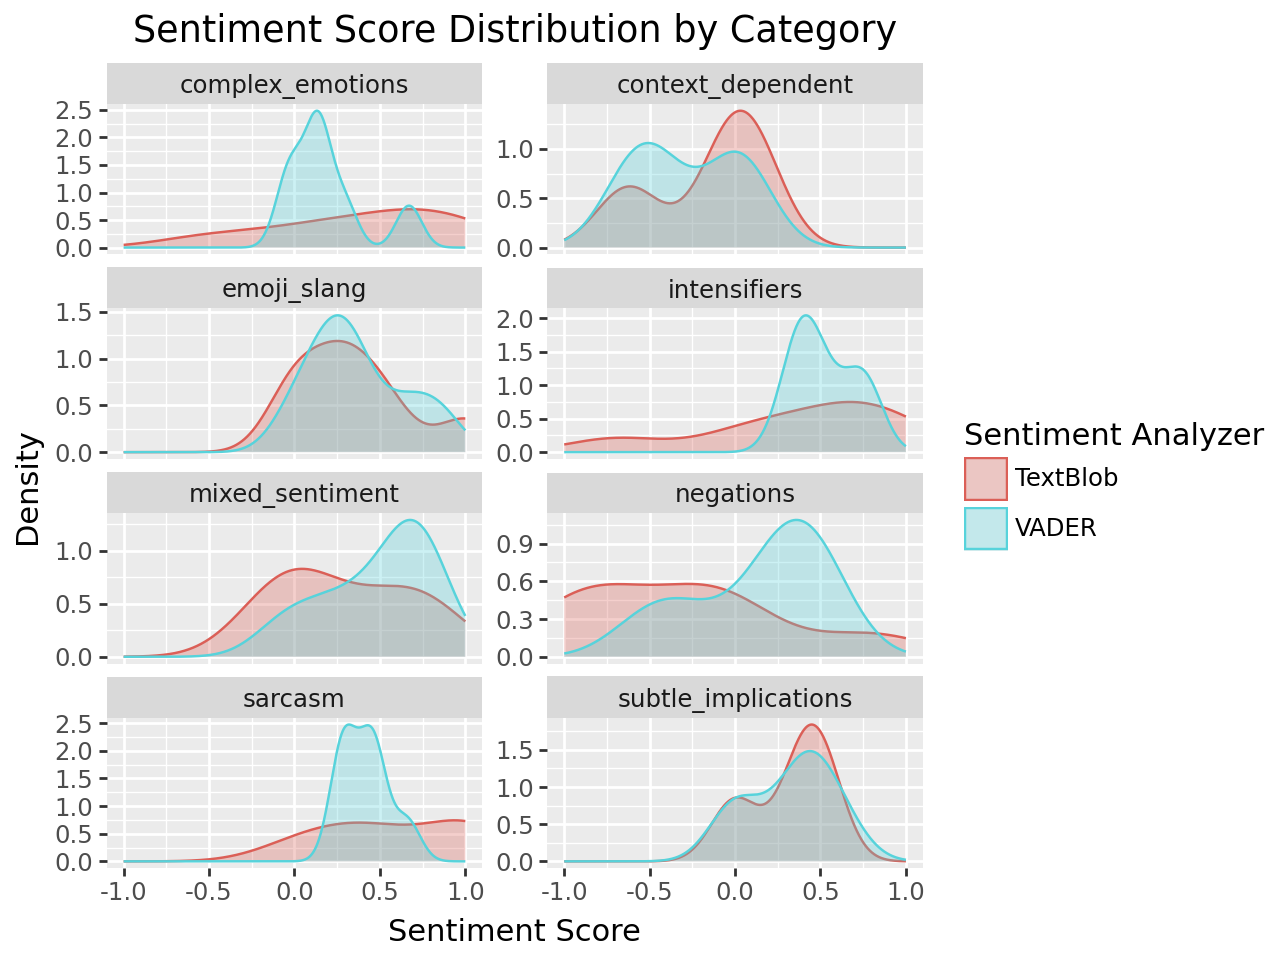

In [13]:
#@title plotting figure - skip this
from plotnine import *
# Reshape data for plotnine using correct column names
plot_data = pd.melt(results_df,
                    id_vars=['Category'],
                    value_vars=['VADER Score', 'TextBlob Polarity'],
                    var_name='scorer',
                    value_name='sentiment')

# Clean up the scorer names for legend
plot_data['scorer'] = plot_data['scorer'].map({
    'VADER Score': 'VADER',
    'TextBlob Polarity': 'TextBlob'
})

# Create the plot
(ggplot(plot_data, aes(x='sentiment',
                       fill='scorer',
                       color='scorer')) +
 geom_density(alpha=0.3) +
 facet_wrap('~ Category', scales='free_y', ncol=2) +
 labs(x='Sentiment Score',
      y='Density',
      title='Sentiment Score Distribution by Category',
      fill='Sentiment Analyzer',
      color='Sentiment Analyzer') +
 scale_x_continuous(limits=[-1, 1]))

So it is not totally a good idea to compare differences or means directly.

But we can use our understanding of how each score "behaves" (differs from the mean) to make a more fair comparison

First, we can calculate **standard deviation** -- an estimate of how variable is each of our polarity scores

In [30]:
print(results_df[['VADER Score', 'TextBlob Polarity']].std())
print(results_df[['VADER Score', 'TextBlob Polarity']].mean())

VADER Score          0.351705
TextBlob Polarity    0.503919
dtype: float64
VADER Score          0.269834
TextBlob Polarity    0.233068
dtype: float64


Now I can recalculate my original polarity into "how far the polarity is from mean, estimated in 'typical differences' (standard deviations). Stats people call this z-scores

In [31]:
from scipy import stats
results_df['VADER_zscore'] = stats.zscore(results_df['VADER Score'])
results_df['TextBlob_zscore'] = stats.zscore(results_df['TextBlob Polarity'])

In [34]:
results_df[['Sentence', 'VADER Score', 'VADER_zscore', 'TextBlob Polarity', 'TextBlob_zscore']]

,Sentence,VADER Score,VADER_zscore,TextBlob Polarity,TextBlob_zscore
0,"Oh great, another meeting that could've been an email!",0.6588,1.110915,1.000000,1.528776
1,Well isn't this just perfect...,0.2732,0.009614,1.000000,1.528776
2,How wonderful to spend my Sunday fixing someone else's mistakes,0.2960,0.074732,1.000000,1.528776
3,Thanks for nothing,0.4404,0.487149,0.200000,-0.065917
4,You're so helpful /s,0.4754,0.587111,0.000000,-0.464590
...,...,...,...,...,...
107,I hate that I love this so much,0.1280,-0.405088,-0.033333,-0.531035
108,Painfully beautiful performance,0.1280,-0.405088,0.850000,1.229771
109,Delightfully disturbing masterpiece,0.6705,1.144331,-0.500000,-1.461272
110,Nostalgically heartbreaking in the best way,0.2960,0.074732,1.000000,1.528776


(reminder you don't need to understand this code)

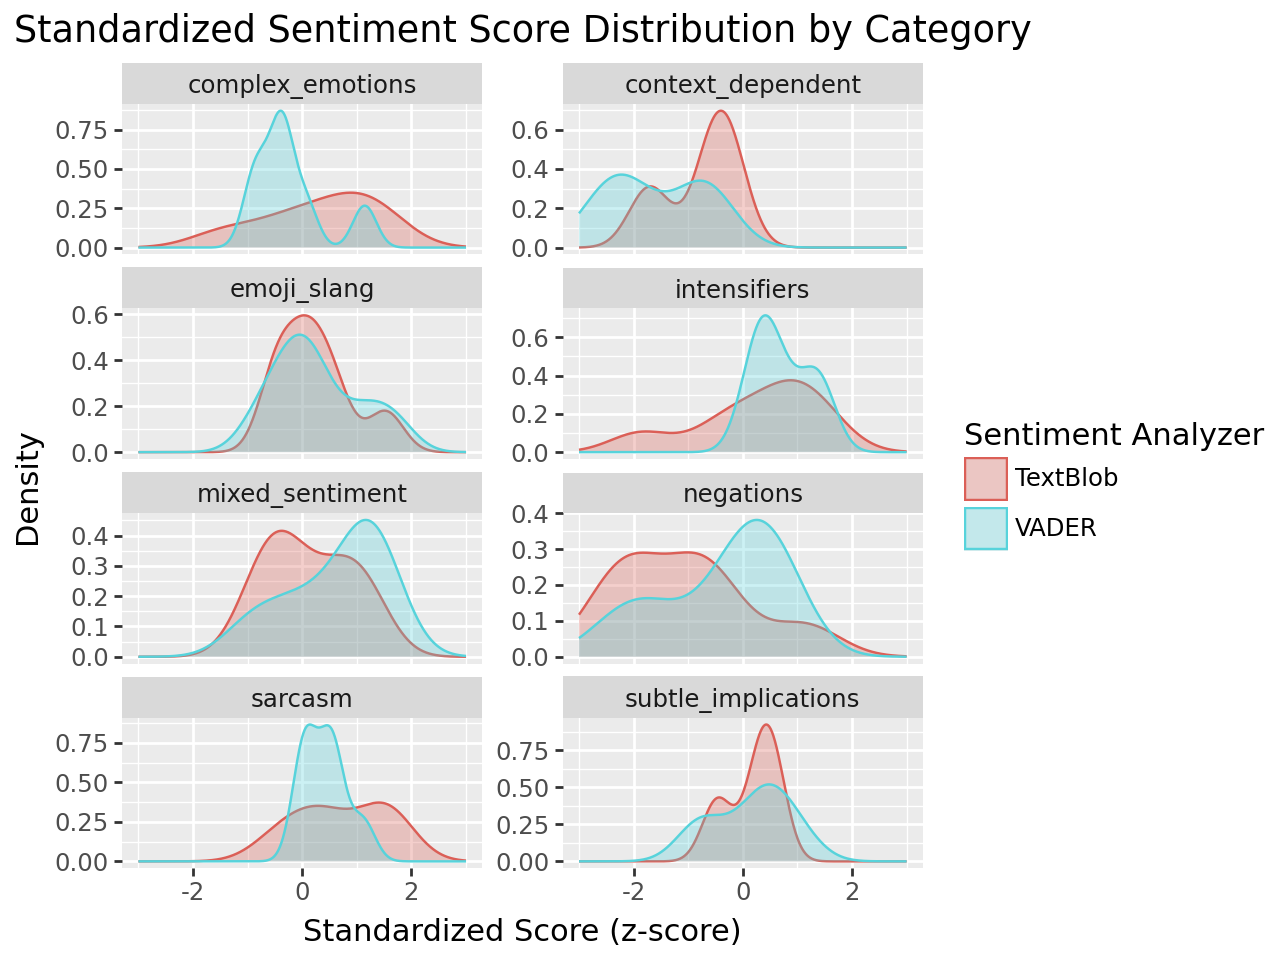

In [18]:
#@title second plot - skip the code
plot_data = pd.melt(results_df,
                    id_vars=['Category'],
                    value_vars=['VADER_zscore', 'TextBlob_zscore'],
                    var_name='scorer',
                    value_name='z_score')

# Clean up the scorer names for legend
plot_data['scorer'] = plot_data['scorer'].map({
    'VADER_zscore': 'VADER',
    'TextBlob_zscore': 'TextBlob'
})

# Create the plot
(ggplot(plot_data, aes(x='z_score',
                       fill='scorer',
                       color='scorer')) +
 geom_density(alpha=0.3) +
 facet_wrap('~ Category', scales='free_y', ncol=2) +
 labs(x='Standardized Score (z-score)',
      y='Density',
      title='Standardized Sentiment Score Distribution by Category',
      fill='Sentiment Analyzer',
      color='Sentiment Analyzer') +
 scale_x_continuous(limits=[-3, 3]))  # typical range for z-scores